---
layout: page
title: S&P 500 Index
---

In [1]:
""" import library and package dependencies """
from sys import path
path.insert(0, '../src')
import pandas as pd
from datetime import datetime
from IPython.display import display, Markdown

from data_loader import get_exchange_historical_data, get_exchange_data
from chart_format import StandardChart, LogChart, PercentileChart
from data_functions import Percentiles

The S&P 500 Index from Standard & Poor's is a market-capitalization-weighted index tracking the 500 largest publicly traded companies in the US. 

The S&P 500 is widely considered one of the best gauges of overall stock market performance because of its depth and diversity, tracking the top performing companies by market capitalization.

In [2]:
""" 
Load historical data
"""
sx_symbol = 'SPX'

df = pd.DataFrame()

# Try collecting data from 1940
# For each decade from 1940 to 2020 get 10 years of data if not in local cache
for decade in range(1940, 2020, 10):
    from_date = str(decade) + '-01-01'
    to_date = str(decade + 9) + '-12-31'
    local_file = '../data/' + sx_symbol.lower() + '_HistoricalData_' + str(decade) + '.csv'
    df_decade = get_exchange_historical_data(local_file, '^GSPC', from_date, to_date)
    df = pd.concat([df, df_decade])

#for decade in range(1940, 2020, 10):
#    from_date = str(decade) + '-01-01'
#    to_date = str(decade + 9) + '-12-31'
#    print(from_date, to_date)
#
#current_year = datetime.now().year
#for year in range(2020, current_year):
#    from_date = str(year) + '-01-01'
#    to_date = str(year) + '-12-31'
#    print(from_date, to_date)
#
#print(current_year)
#print('Try current year')
#from_date = str(current_year) + '-01-01'
#to_date = str(current_year) + '-12-31'
#print(from_date, to_date)

1940-01-01 1949-12-31
1950-01-01 1959-12-31
1960-01-01 1969-12-31
1970-01-01 1979-12-31
1980-01-01 1989-12-31
1990-01-01 1999-12-31
2000-01-01 2009-12-31
2010-01-01 2019-12-31
2020-01-01 2020-12-31
2021-01-01 2021-12-31
2022-01-01 2022-12-31
2023-01-01 2023-12-31
2024-01-01 2024-12-31
2025
Try current year
2025-01-01 2025-12-31


In [3]:
# For each previous year after 2020 get the historical data if not in local cache
current_year = datetime.now().year
for year in range(2020, current_year):
    from_date = str(year) + '-01-01'
    to_date = str(year) + '-12-31'
    local_file = '../data/' + sx_symbol.lower() + '_HistoricalData_' + str(year) + '.csv'
    df_year = get_exchange_historical_data(local_file, '^GSPC', from_date, to_date)
    df = pd.concat([df, df_year])

In [4]:
""" 
Load recent data for current year (always downlaod / refresh)
"""
from_date = str(current_year) + '-01-01'
to_date = str(current_year) + '-12-31'
local_file = '../data/' + sx_symbol.lower() + '_HistoricalData_' + str(current_year) + '.csv'
# For current year always download the data and overwrite the local cache
df_year = get_exchange_data(local_file, '^GSPC', from_date, to_date)

df = pd.concat([df, df_year])

In [5]:
""" Data Transformation """
data_column = 'Close'

# Ensure 'Date' column is timezone naive
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df['Date'] = df['Date'].dt.tz_localize(None)
df.set_index('Date', inplace=True)

# Set 'last_index' to the last date with a valid value (so I can display 'as of <date>' in chart title)
last_index = df[data_column].last_valid_index()


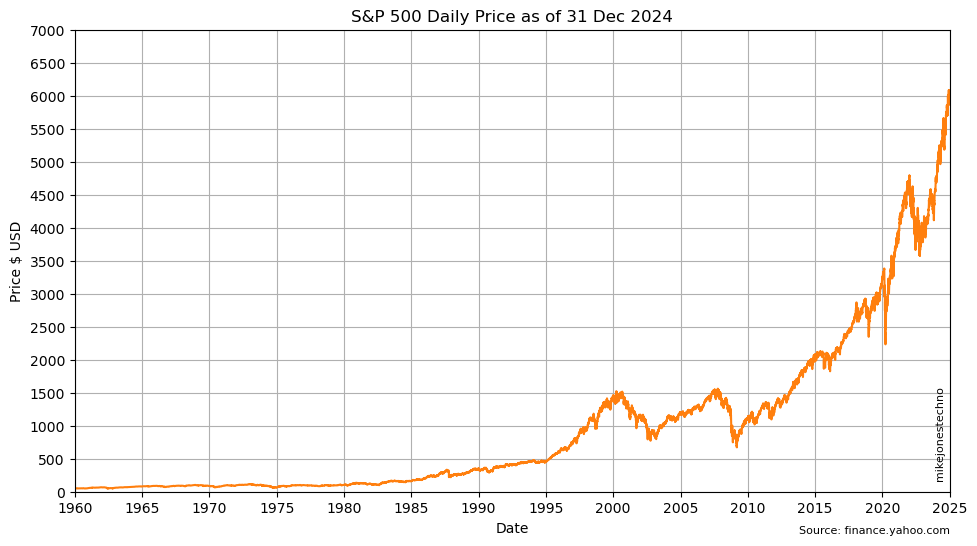

In [6]:
""" Show simple chart """
max_value = df[data_column].max()
top_limit = max_value + (1000 - max_value % 1000) # round UP to next 1000

chart_params = {
    'chart_title': 'S&P 500 Daily Price as of ' + last_index.strftime('%d %b %Y'), 
    'chart_source': 'Source: finance.yahoo.com', 
    'y_label': 'Price $ USD', 
    'y_ticks': 500,
    'x_label': 'Date', 
    'x_ticks': 5,
    'top_limit': top_limit,
    'start_year': 1960,
    'data_column': data_column
}

standard_chart = StandardChart(**chart_params)
plt, colors = standard_chart.base_chart(df)

plt.plot(df.index, df[data_column], color=colors[1]['color'])

plt.show()

The compound annual growth over time appears to be an exponential curve. Plotting the **same data** with a logarithmic y-axis scale helps visualize the bursts of growth in earlier years that would otherwise be hidden by the volatility of spikes in later years.

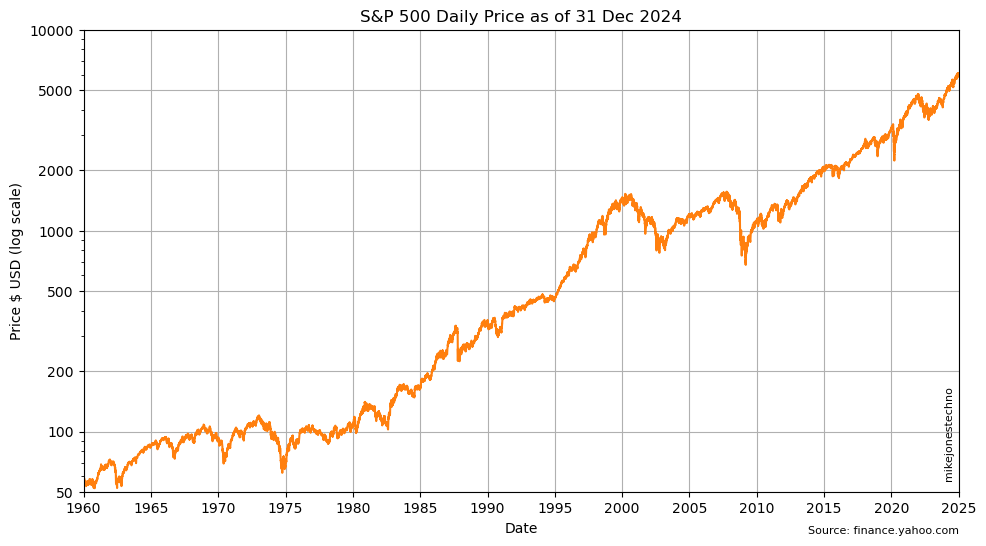

In [7]:
""" y-axis log scale """
log_chart_params = chart_params.copy()
log_chart_params['y_label'] = chart_params['y_label'] + ' (log scale)'
log_chart_params['y_ticks'] = [50, 100, 200, 500, 1000, 2000, 5000, 10000]
del log_chart_params['top_limit']
log_chart = LogChart(**log_chart_params)
plt, colors = log_chart.base_chart(df)
plt.plot(df.index, df[data_column], color=colors[1]['color'])
plt.show()

The logarithmic scale shows a period of volatility between 1965 and 1980 where the price was flat, trending very slightly up.

The sudden almost 45' angle from 1980 indicates significant growth, climbing 10x over 20 years, from $100 in 1980 to over $1,000 in the year 2000. 

The S&P 500 hit a ten year period of volatility between 2000 and 2010 which wiped out almost 1/2 of the value at the lowest point.

Another 45' climb over the next 15 years resulted in another 5x from $1,000 in 2010 to $5,000 around 2025.

The logarithmic scale shows the S&P 500 has consistent multi-year periods of high growth performance (with flat sideways trends through periods of high volatility).


In [8]:
""" Calculate and print percentiles table """
""" Year over Year (YoY) change based on 252 trading days per year """
periods_per_year = 252
df['YoY'] = df[data_column].pct_change(periods=periods_per_year)*100
multi_years = [1, 3, 5, 10, 20]
percentiles = Percentiles(df, 'YoY', periods_per_year, multi_years)
df = percentiles.calculate_percentiles(df)
df_last_percentiles = percentiles.calculate_last_percentiles(df)

In [9]:
percentiles.display_percentile_intro()


Calculating the 25th and 75th percentile over a multi year time horizon helps smooth out the anomolies and visualize the lower and upper long term trends.
    

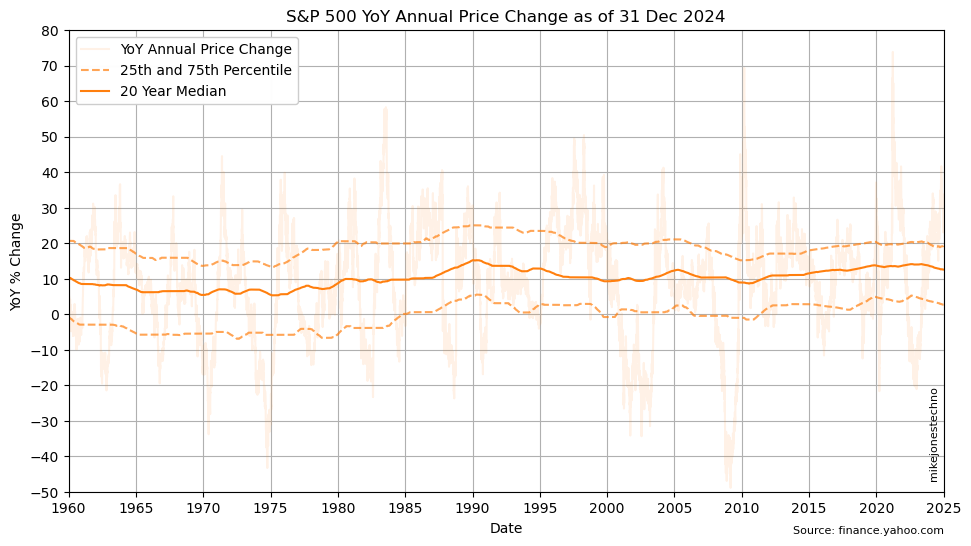

In [10]:
yoy_chart_params = chart_params.copy()
yoy_chart_params['chart_title'] = 'S&P 500 YoY Annual Price Change as of ' + last_index.strftime('%d %b %Y')
yoy_chart_params['data_column'] = 'YoY'
yoy_chart_params['y_label'] = 'YoY % Change'
yoy_chart_params['y_ticks'] = 10
yoy_chart_params['color_index'] = 1
yoy_chart_params.pop('top_limit', None)
percentile_chart = PercentileChart(percentiles.percentiles, percentiles.multi_years[4], **yoy_chart_params)
plt = percentile_chart.plot_percentiles(df) 
plt.show()

In [11]:
percentiles.display_percentile_summary(df_last_percentiles, 'YoY change')
percentiles.display_dataframe_table(df_last_percentiles)


Over the last 3 years the median (50th percetile) YoY change is 13.81%; The mean (average) YoY change is 9.71%.

Over the last 20 years the median (50th percetile) YoY change is 11.50%; The mean (average) YoY change is 9.48%.
    

Years,25th percentile,50th percentile,75th percentile,mean
1,22.85,26.12,31.05,26.82
3,-6.78,13.81,23.77,9.71
5,2.49,16.15,26.85,14.70
10,2.69,12.58,19.25,11.76
20,2.84,11.50,18.00,9.48


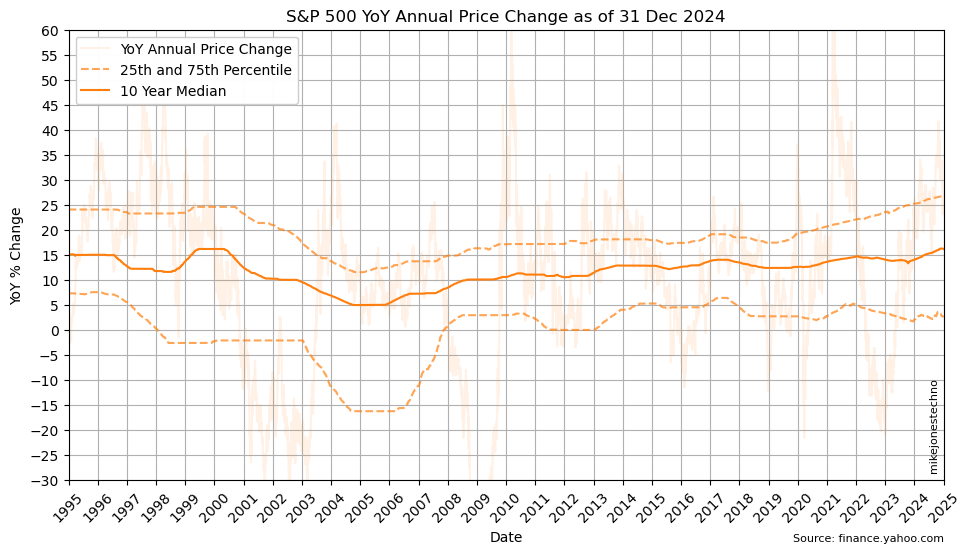

In [12]:
""" Change chart variables to plot from 1995 and multi year window not extended multi year window """
yoy_chart_params['start_year'] = 1995
yoy_chart_params['x_ticks'] = 1
yoy_chart_params['y_ticks'] = 5
yoy_chart_params['bottom_limit'] = -30
yoy_chart_params['top_limit'] = 60
yoy_chart_params['legend_location'] = 'upper left'
percentile_chart = PercentileChart(percentiles.percentiles, percentiles.multi_years[3], **yoy_chart_params)
plt = percentile_chart.plot_percentiles(df)
plt.show()

In [13]:

display(Markdown(f"""
> ℹ Given the multi-decade history, the data suggests high confidence using a baseline stock market performance of { "{:,.0f}".format(df_last_percentiles.loc[percentiles.multi_years[-1], percentiles.percentiles[1]]) }% with some uncertainty or risk that stocks can go up or down for several years at a time. Note this does not take inflation into consideration.
"""))


> ℹ Given the multi-decade history, the data suggests high confidence using a baseline stock market performance of 11% with some uncertainty or risk that stocks can go up or down for several years at a time. Note this does not take inflation into consideration.


In [14]:
%%capture
# Magic store dataframe to share with combo notebook
df_spx = df
%store df_spx